In [27]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
def prob(x):
    return 1 - np.exp(-x)

In [32]:
def rand(shape, min=0, max=1):
    return np.random.uniform(low=min, high=max, size=shape)

In [4]:
def get_F(shape, min_=0, max_=1, α=1e-8):
    """
    Generates a random F matrix with a E-community that connects all nodes with a weight { α }
    """
    
    F = rand(shape, min_, max_)
    return F

In [34]:
def log_likelihood(fu, f_sum, fv_conns):
    prob_conns = prob( fu@fv_conns.T)
    conns_sum = np.log(prob_conns).sum()
    
    fv_nconns = f_sum - fu - fv_conns.sum(axis=0)
    nconns_sum = (fu * fv_nconns).sum()
    return conns_sum - nconns_sum

In [5]:
def big_clam(conns, F, LR=0.00001, n_iters=1000, α = 1e-8, MAX_VALUE=None):
    N,K = F.shape
    nodes = np.arange(N, dtype=int)
    
    for i in tqdm(range(n_iters)): 
        f_sum = F.sum(axis=0)
        #randomize epoch order
        np.random.shuffle(nodes)

        for u in nodes:
            fv_conns = F[conns[u]]
            #F vector of node u
            fu = F[u]

            #connection probablity of fu to each fv
            scores=fu@fv_conns.T
            prob_con = prob(scores)

            fraction = (1 - prob_con)/prob_con
            conns_factor = (fv_conns.T @ fraction)

            #optimization of non-connection neighbours sum
            nconns_factor = f_sum - fu - fv_conns.sum(axis=0)

            # calculate gradient
            u_grad = conns_factor - nconns_factor
            u_grad = LR * u_grad

            #update the community likelihoods for each node
            F[u] += u_grad
            clip_idx = F[u] < α
            F[u, clip_idx] = α
            
    f_sum = F.sum(axis=0)
    final_ll=np.array(
        [-log_likelihood(F[u], f_sum, F[conns[u]]) for u in range(N)]
    ).sum()
    return final_ll

In [51]:
def get_communities(F, thresh):
    NN, k = F.shape
    
    comunities = {}
    for c in range(k):
        locs = np.where(F[:, c]>=thresh)[0]
        comunities[c] = set(list(locs))
    return comunities

In [6]:
def get_graph_from_communities(F):
    N, k = F.shape
    graph = np.zeros((N,N))
    
    for i in range(N):
        for j in range(N):
            if i!=j:
                graph[i,j] = prob(F[i]@F[j])
    
    return graph

In [25]:
def plot_graph(G, show_labels=False, node_size=10, figsize=(6,6)):
    f, ax = plt.subplots(1,1, figsize=figsize)
    display = display = nx.spring_layout(G)
    
    nx.draw_networkx_nodes(G, nodelist=G.nodes, pos=display, node_size = node_size, ax=ax, alpha=0.3)
    
    if show_labels==True:
        nx.draw_networkx_labels(G, pos=display, ax=ax)
    
    nx.draw_networkx_edges(G, pos=display, edgelist=G.edges, ax=ax, arrows=False)

In [7]:
links = pd.read_csv("data/stack_network_links.csv")
nodes = pd.read_csv("data/stack_network_nodes.csv")

In [8]:
links.head()

,source,target,value
0,azure,.net,20.933192
1,sql-server,.net,32.322524
2,asp.net,.net,48.407030
3,entity-framework,.net,24.370903
4,wpf,.net,32.350925


In [9]:
nodes.head()

,name,group,nodesize
0,html,6,272.45
1,css,6,341.17
2,hibernate,8,29.83
3,spring,8,52.84
4,ruby,3,70.14


In [14]:
def get_adj(nodes, edges):
    NN = len(nodes.name.unique())
    mappings = {}
    c=0
    adj = np.zeros((NN,NN))
    
    for e in edges.index:
        i, j = edges.loc[e, "source"], edges.loc[e, "target"]
        if i in mappings:
            i = mappings[i]
        else:
            mappings[i]=i=c
            c+=1
        if j in mappings:
            j = mappings[j]
        else:
            mappings[j]=j=c
            c+=1
        adj[i, j] = edges.loc[e, "value"]
    return adj, mappings
graph, maps = get_adj(nodes, links)

In [15]:
A = (graph>0)*1

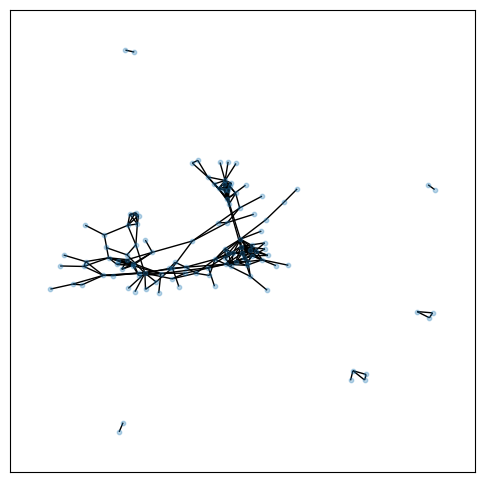

In [30]:
G = nx.Graph()
G.add_edges_from(np.argwhere(A!=0))
plot_graph(G)

In [19]:
rev_map = {value:key for key, value in maps.items()}

In [21]:
ϵ = np.argwhere(A!=0).shape[0] / A.shape[0] / (A.shape[0]-1)
ϵ

0.03737604881769642

In [22]:
δ = np.sqrt(-np.log(1-ϵ))
δ

0.19517284816936337

In [23]:
conns = {i : np.where(node_conns!=0)[0] for i, node_conns in enumerate(A)}

In [24]:
conns[0]

array([ 1,  3,  8, 20, 38], dtype=int64)

In [35]:
NN = len(A)
k=8
MAX=None
F=get_F((NN, k))

init_ll = np.array([
    -log_likelihood(F[u], F.sum(axis=0), F[conns[u]]) for u in range(F.shape[0])
]).sum()

print("Initial Evaluation: ", init_ll)

Initial Evaluation:  25232.203262303512


In [48]:
final_ll = big_clam(conns, F, n_iters=5000, LR=0.00001, α=1e-4, MAX_VALUE=MAX)
print("Final Evaluation: ", final_ll)

  0%|          | 0/5000 [00:00<?, ?it/s]

Final Evaluation:  982.5883520828148


In [46]:
from sklearn.metrics import log_loss

In [49]:
log_loss( A.flatten(), get_graph_from_communities(F).flatten() )

0.07429779599870061

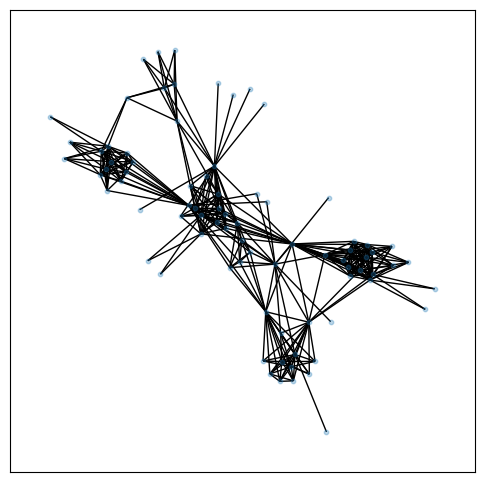

In [56]:
G = nx.Graph()
G.add_edges_from(np.argwhere( (get_graph_from_communities(F)>δ)*1!=0) )
plot_graph(G)

In [52]:
communities = get_communities(F, δ)

In [53]:
list(map(len, communities.values()))

[17, 15, 18, 11, 15, 16, 13, 15]